## ST590 Project3-Group16
### Student: Autumn Biggie and YiHua Lin


## 1. Introduction: 

The S&P 500 is a capitalization-weighted index of the top 500 publicly traded companies in the United States (top 500 meaning the companies with the largest market cap). The S&P 500 index is a useful index to study because it generally reflects the health of the overall U.S. stock market.

We are going to use S&P 500 Financial Dataset to predict price and to determine the high-quality company

## Predictor Introduction( 4 character variables and 10 numeric variables): 

character variables:

**Symbol-** Ticker symbol used to uniquely identify each company on a particular stock market

**Name-** Legal name of the company

**Sector-** An area of the economy where businesses share a related product or service

**SEC Filings-** Helpful documents relating to a company

numeric variables:

**Price/Earnings(P/E)-** financial indicator equal to the ratio of the market value of a share to the annual earnings per share

**Dividend yield-** the ratio of the annual dividend per share to the share price. This value is most often expressed as a percentage.

**Earnings/Share(EPS) -** financial indicator equal to the ratio of the company's net profit available for distribution to the average annual number of ordinary shares.

**EBITDA-** an analytical indicator equal to the amount of profit before deduction of expenses on payment of interest, taxes, depreciation and amortization.Often used as a proxy for its profitability

**Price/Sales(P/S)-** financial indicator equal to the ratio of a company's market capitalization to its annual revenue.

**Price/book(P/B)-** financial ratio equal to the ratio of the company's current market capitalization to its book value.

**Price-** Price per share of the company

**52 week high-** The annual high of a company’s share price

**52 week low-** The annual low of a company’s share price
        - 
        
**Market Cap-** The market value of a company’s shares (calculated as share price x number of shares)


## Import appropriate modules for starting spark session, using pandas on spark, and accessing math functions

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import scipy.stats as stats
import sqlite3
import pylab as pl
import plotly
import pyspark.pandas as ps
import plotly.graph_objs as go
import seaborn as sns
import sys
import os
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
from plotly.offline import init_notebook_mode, iplot
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import isnan, when, count, col
spark = SparkSession.builder.master('local[*]').appName('my-app').getOrCreate()
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest
from pyspark.ml.regression import RandomForestRegressor

## 2. Data and EDA on Training set

In [105]:
# Read in S&P 500 data set using pandas
financials = pd.read_csv("financials.csv") 
financials.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [106]:
#Dummy variable-sector
financialsj=pd.get_dummies(financials["Sector"])
#join dummy dataframe to pandas dataframe
financials=financials.join(financialsj)
financials.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,...,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunication Services,Utilities
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,...,0,0,0,0,1,0,0,0,0,0
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,...,0,0,0,0,1,0,0,0,0,0
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,...,0,0,0,1,0,0,0,0,0,0
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,...,0,0,0,1,0,0,0,0,0,0
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,...,0,0,0,0,0,1,0,0,0,0


In [107]:
findata = spark.createDataFrame(financials) #convert to spark data frame
findata.show()

+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+----------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|Symbol|                Name|              Sector| Price|Price/Earnings|Dividend Yield|Earnings/Share|52 Week Low|52 Week High|     Market Cap|    EBITDA|Price/Sales|Price/Book|         SEC Filings|Consumer Discretionary|Consumer Staples|Energy|Financials|Health Care|Industrials|Information Technology|Materials|Real Estate|Telecommunication Services|Utilities|
+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+----------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+------

In [108]:
#split pandas dataframe then transfer train and test set to spark
# Create training and test set with 80%/20% split, returning #obs in each set
# We will use THESE sets during modeling
train, test = findata.randomSplit([0.8, 0.2], seed = 3)
print(train.count(), test.count())
# Convert training set above to pandas-on-spark data set 
fintrain = train.to_pandas_on_spark()
fintest = test.to_pandas_on_spark()

398 107


In [109]:
# check the columns ( pysqldataframe)
train.printSchema()
train.describe()

root
 |-- Symbol: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Price/Earnings: double (nullable = true)
 |-- Dividend Yield: double (nullable = true)
 |-- Earnings/Share: double (nullable = true)
 |-- 52 Week Low: double (nullable = true)
 |-- 52 Week High: double (nullable = true)
 |-- Market Cap: double (nullable = true)
 |-- EBITDA: double (nullable = true)
 |-- Price/Sales: double (nullable = true)
 |-- Price/Book: double (nullable = true)
 |-- SEC Filings: string (nullable = true)
 |-- Consumer Discretionary: long (nullable = true)
 |-- Consumer Staples: long (nullable = true)
 |-- Energy: long (nullable = true)
 |-- Financials: long (nullable = true)
 |-- Health Care: long (nullable = true)
 |-- Industrials: long (nullable = true)
 |-- Information Technology: long (nullable = true)
 |-- Materials: long (nullable = true)
 |-- Real Estate: long (nullable = true)
 |-- Telecommunication Se

DataFrame[summary: string, Symbol: string, Name: string, Sector: string, Price: string, Price/Earnings: string, Dividend Yield: string, Earnings/Share: string, 52 Week Low: string, 52 Week High: string, Market Cap: string, EBITDA: string, Price/Sales: string, Price/Book: string, SEC Filings: string, Consumer Discretionary: string, Consumer Staples: string, Energy: string, Financials: string, Health Care: string, Industrials: string, Information Technology: string, Materials: string, Real Estate: string, Telecommunication Services: string, Utilities: string]

In [110]:
#checking for null values( pysqldataframe)
train.select([count(when(isnan(c), c)).alias(c) for c in train.columns]).show()

+------+----+------+-----+--------------+--------------+--------------+-----------+------------+----------+------+-----------+----------+-----------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|Symbol|Name|Sector|Price|Price/Earnings|Dividend Yield|Earnings/Share|52 Week Low|52 Week High|Market Cap|EBITDA|Price/Sales|Price/Book|SEC Filings|Consumer Discretionary|Consumer Staples|Energy|Financials|Health Care|Industrials|Information Technology|Materials|Real Estate|Telecommunication Services|Utilities|
+------+----+------+-----+--------------+--------------+--------------+-----------+------------+----------+------+-----------+----------+-----------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|     0|   0|     0|    0|             2|             0|  

In [111]:
#change the column name for easier EDA
train = train.select([func.col(col).alias(col.replace('/', '_')) for col in train.columns])
train = train.select([func.col(col).alias(col.replace(' ', '_')) for col in train.columns])
train.show(5)

+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+---------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+-----------+----------------------+---------+-----------+--------------------------+---------+
|Symbol|                Name|              Sector| Price|Price_Earnings|Dividend_Yield|Earnings_Share|52_Week_Low|52_Week_High|     Market_Cap|   EBITDA|Price_Sales|Price_Book|         SEC_Filings|Consumer_Discretionary|Consumer_Staples|Energy|Financials|Health_Care|Industrials|Information_Technology|Materials|Real_Estate|Telecommunication_Services|Utilities|
+------+--------------------+--------------------+------+--------------+--------------+--------------+-----------+------------+---------------+---------+-----------+----------+--------------------+----------------------+----------------+------+----------+-----------+---------

In [112]:
#remove the missing data

train=train.na.drop()

In [113]:
#summary for numeric variables
train.select(train.columns[1:10]).summary().show()

+-------+-------------+--------------------+------------------+------------------+------------------+------------------+------------------+----------------+--------------------+
|summary|         Name|              Sector|             Price|    Price_Earnings|    Dividend_Yield|    Earnings_Share|       52_Week_Low|    52_Week_High|          Market_Cap|
+-------+-------------+--------------------+------------------+------------------+------------------+------------------+------------------+----------------+--------------------+
|  count|          389|                 389|               389|               389|               389|               389|               389|             389|                 389|
|   mean|         null|                null|102.57997429305912|23.854832904884322|1.8498367506966582|3.6892544987146523|121.22018920308483|82.8720673084833|4.665931922568381E10|
| stddev|         null|                null| 127.3932017265182|31.122985096630753|1.5477669844389308| 5.389155

In [114]:
#summary for categorical variables

train.groupBy('Sector').count().select(func.col("Sector"),func.col("count")).show()
pie1=train.groupBy('Sector').count().select(func.col("Sector"),func.col("count"))

+--------------------+-----+
|              Sector|count|
+--------------------+-----+
|         Health Care|   45|
|              Energy|   23|
|Information Techn...|   50|
|Telecommunication...|    2|
|         Real Estate|   27|
|           Materials|   21|
|Consumer Discreti...|   67|
|           Utilities|   21|
|    Consumer Staples|   28|
|         Industrials|   55|
|          Financials|   50|
+--------------------+-----+



## Outlier

In [62]:
# Describe numeric variables in data set
fintrain.describe()

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunication Services,Utilities
count,398.000000,396.000000,398.000000,398.000000,398.000000,398.000000,3.980000e+02,3.980000e+02,398.000000,391.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,102.410754,24.102955,1.842285,3.611382,120.914205,82.683013,4.665611e+10,3.516603e+09,3.906511,11.616547,0.170854,0.072864,0.062814,0.125628,0.118090,0.145729,0.125628,0.052764,0.067839,0.005025,0.052764
std,126.451627,32.160682,1.544059,5.604250,147.115407,104.402618,8.279151e+10,6.894029e+09,3.443362,69.944221,0.376855,0.260241,0.242934,0.331847,0.323121,0.353278,0.331847,0.223843,0.251786,0.070799,0.223843
min,2.820000,-251.530000,0.000000,-28.010000,6.590000,2.800000,2.626102e+09,-5.067000e+09,0.173970,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.250000,15.390000,0.755124,1.490000,56.580000,37.820000,1.246666e+10,7.367980e+08,1.614736,2.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74.510000,19.710000,1.667825,2.930000,88.000000,63.410000,2.103272e+10,1.561000e+09,2.839671,3.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,116.540000,25.900000,2.669978,5.140000,139.240000,97.880000,4.402709e+10,3.459800e+09,4.703259,6.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1806.060000,305.560000,12.661196,44.090000,2067.990000,1589.000000,8.095080e+11,7.938600e+10,20.094294,1318.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [115]:
#remove outlier
fintrain=fintrain[fintrain['Price']<400]
fintrain.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunication Services,Utilities
0,A,Agilent Technologies Inc,Health Care,65.05,27.45,0.875698,2.10,75.00,49.23,2.198461e+10,1.094000e+09,6.493563,4.56,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0
1,AAL,American Airlines Group,Industrials,48.60,9.92,0.778210,3.91,59.08,39.21,2.459485e+10,5.761000e+09,0.580226,6.03,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,1,0,0,0,0,0
2,AAPL,Apple Inc.,Information Technology,155.15,16.86,1.579541,9.20,180.10,131.12,8.095080e+11,7.938600e+10,3.458609,5.66,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,0,1,0,0,0,0
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.05,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0
4,ABC,AmerisourceBergen Corp,Health Care,91.55,15.54,1.613246,1.64,106.27,71.90,2.058770e+10,9.918840e+08,0.173970,9.73,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0


In [116]:
train=train.filter(train.Price<400)

<AxesSubplot:xlabel='Sector', ylabel='Price'>

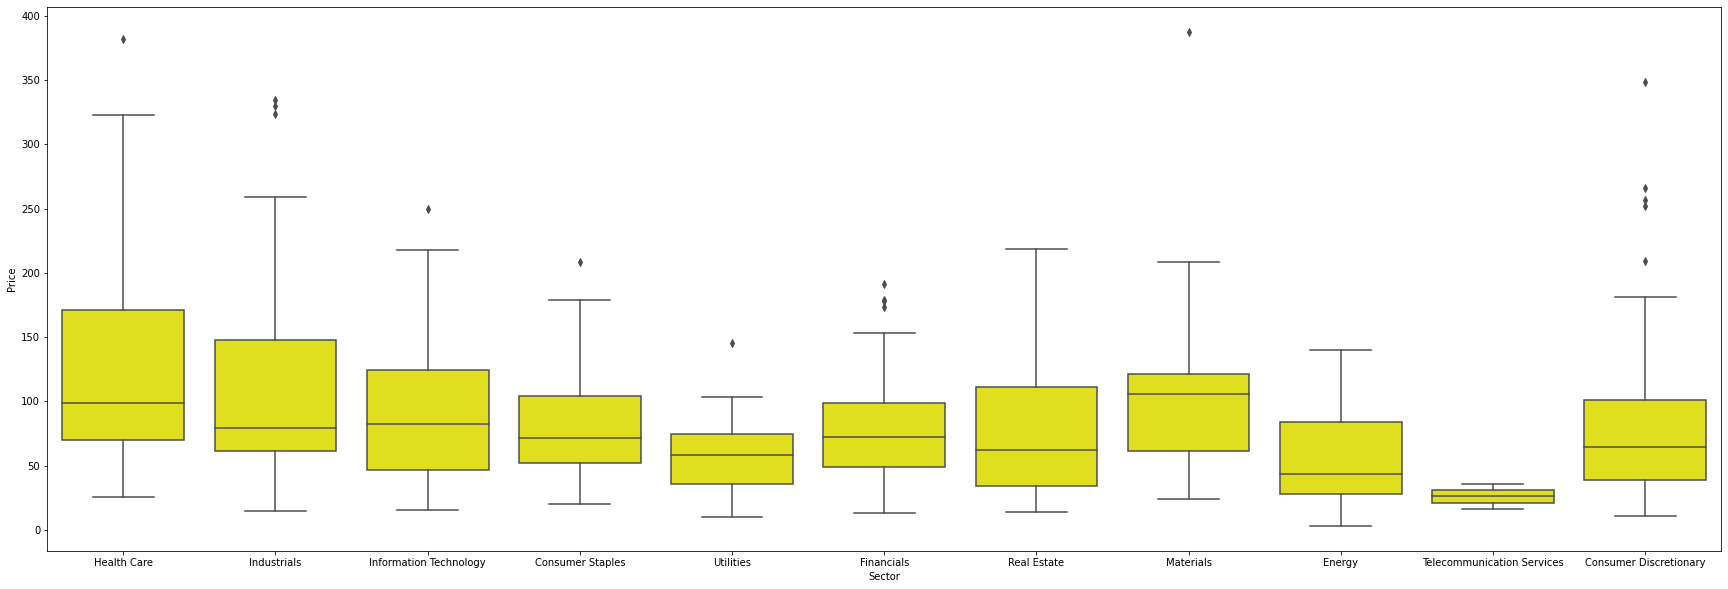

In [117]:
# boxplot of price 
fig, ax = plt.subplots(1, 1, figsize=(30,10))
sns.boxplot(x='Sector',y='Price',data=train.toPandas(),color='yellow')

In [84]:
# different sectors price pencentile and check the outlier 
# Find quantiles of Price
#fintrain is ponda_on_sprak
findata_pd_energy=fintrain[fintrain['Sector']=="Energy"]
len(findata_pd_energy)
findata_pd_energy.Price.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

0.01      2.82
0.25     27.50
0.50     43.00
0.75     76.07
0.99    140.09
Name: Price, dtype: float64

C:\Users\yihua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



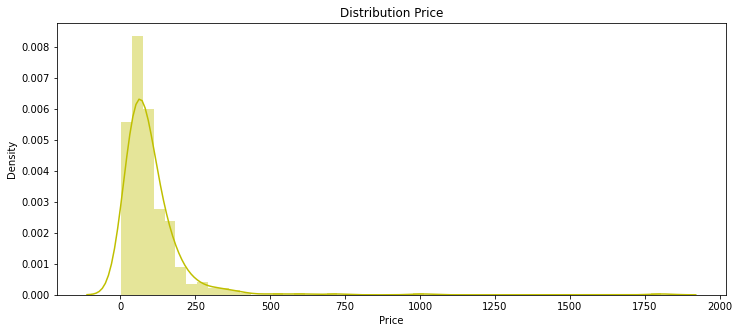

In [63]:
 #distribution of price
train_pd=train.toPandas()
pl.figure(figsize=(12,5))
pl.title("Distribution Price")
ax = sns.distplot(train_pd["Price"], color = 'y')

In [61]:
# different sectors price pencentile and check the outlier 
# Find quantiles of Price
#fintrain is ponda_on_sprak
findata_pd_HealthCare=fintrain[fintrain['Sector']=="Health Care"]
len(findata_pd_HealthCare)
findata_pd_HealthCare.Price.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

0.01     25.20
0.25     70.85
0.50     96.42
0.75    178.00
0.99    601.00
Name: Price, dtype: float64

### 3. Plot- Matplotlib and Seaborn

In [9]:
# Return unique values of Sector variable
findata.select('Sector').distinct().show()

+--------------------+
|              Sector|
+--------------------+
|         Health Care|
|              Energy|
|Information Techn...|
|Telecommunication...|
|         Real Estate|
|           Materials|
|Consumer Discreti...|
|           Utilities|
|    Consumer Staples|
|         Industrials|
|          Financials|
+--------------------+



In [10]:
# Determining number of each company in each sector
findata.groupBy('Sector','Name').count().show(truncate=False)

+----------------------+-------------------------+-----+
|Sector                |Name                     |count|
+----------------------+-------------------------+-----+
|Information Technology|Activision Blizzard      |1    |
|Financials            |Capital One Financial    |1    |
|Consumer Discretionary|CBS Corp.                |1    |
|Information Technology|Netflix Inc.             |1    |
|Financials            |Allstate Corp            |1    |
|Financials            |Brighthouse Financial Inc|1    |
|Consumer Discretionary|Time Warner Inc.         |1    |
|Information Technology|Autodesk Inc             |1    |
|Industrials           |Eaton Corporation        |1    |
|Health Care           |Medtronic plc            |1    |
|Consumer Staples      |Sysco Corp.              |1    |
|Energy                |Kinder Morgan            |1    |
|Health Care           |DaVita Inc.              |1    |
|Financials            |Northern Trust Corp.     |1    |
|Consumer Discretionary|Norwegi

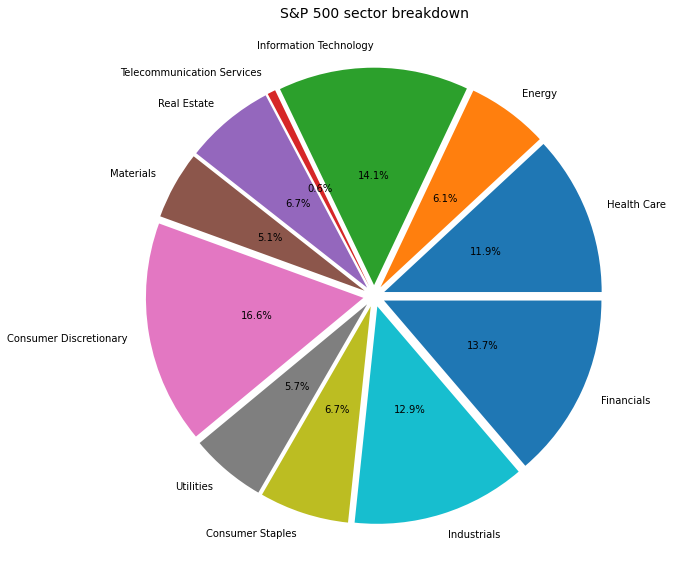

In [11]:
#find company volumn for each Sector
#pie chart
#sparksql to pd
pie1_pd=pie1.toPandas()
type(pie1_pd)
sector_names = list(pie1_pd['Sector'])
sector_values = list(pie1_pd['count']) 

pie, ax = plt.subplots(figsize=[15,10])
plt.pie(x=sector_values, autopct="%.1f%%", explode=[0.05]*len(sector_values), labels=sector_names, pctdistance=0.5)
plt.title("S&P 500 sector breakdown", fontsize=14);
pie.savefig("DeliveryPieChart.png")

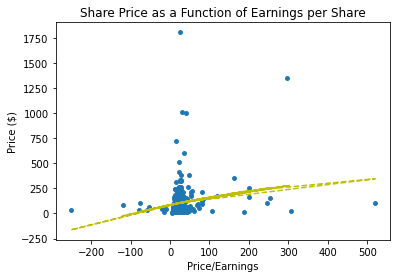

In [24]:
# Use matplotlib to plot earnings per share against price
# sparksql to pd
findata_pd=findata.toPandas()


findata_pd.Sector = findata_pd.Sector.astype('category')

plt.scatter(x = findata_pd["Price_Earnings"].to_numpy(), y =findata_pd["Price"].to_numpy(),
           s = 15)
plt.xlabel("Price/Earnings")
plt.ylabel("Price ($)")
plt.title("Share Price as a Function of Earnings per Share")

x = findata_pd["Price_Earnings"].to_numpy()
y = findata_pd["Price"].to_numpy()

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

plt.plot(x, p(x), "y--")

In [17]:
# View mean Price, Price/Earnings, Earnings/Share, and EBITDA for each sector
#findata.groupby(["Sector"])[["Price","Price_Earnings", "Earnings_Share", "EBITDA"]].agg("mean")
findata.groupBy('Sector').avg().show()

+--------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+
|              Sector|        avg(Price)|avg(Price_Earnings)|avg(Dividend_Yield)|avg(Earnings_Share)|  avg(52_Week_Low)| avg(52_Week_High)|     avg(Market_Cap)|         avg(EBITDA)|  avg(Price_Sales)|   avg(Price_Book)|
+--------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+
|         Health Care|            133.95| 23.596610169491523| 0.9118273960338983|  4.861694915254238|162.77119661016948|104.94939711864407|5.419634146335593...| 3.642433186440678E9| 4.921210154745763| 9.123898305084747|
|              Energy|58.941666666666656| 35.675333333333334| 1.9609847370000002|             -1.645| 74.17533333333334|

In [78]:
# Create categorical version of Price variable with levels "Low" "Medium" and "High" based on quantiles above

from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import *

def categorizer(price):
    if price < 46.25:
        return "Low"
    elif price < 116.54:
        return "Mid"
    else:
        return "High"
    
pricecat_udf = udf(categorizer, StringType())
fintrain = train.withColumn("Price_cat", pricecat_udf("Price")).to_pandas_on_spark()
fintrain.head()

,Symbol,Name,Sector,Price,Price_Earnings,Dividend_Yield,Earnings_Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price_Sales,Price_Book,SEC_Filings,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Industrials,Information_Technology,Materials,Real_Estate,Telecommunication_Services,Utilities,Price_cat
0,A,Agilent Technologies Inc,Health Care,65.05,27.45,0.875698,2.10,75.00,49.23,2.198461e+10,1.094000e+09,6.493563,4.56,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0,Mid
1,AAL,American Airlines Group,Industrials,48.60,9.92,0.778210,3.91,59.08,39.21,2.459485e+10,5.761000e+09,0.580226,6.03,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,1,0,0,0,0,0,Mid
2,AAPL,Apple Inc.,Information Technology,155.15,16.86,1.579541,9.20,180.10,131.12,8.095080e+11,7.938600e+10,3.458609,5.66,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,0,0,1,0,0,0,0,High
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.05,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0,Mid
4,ABC,AmerisourceBergen Corp,Health Care,91.55,15.54,1.613246,1.64,106.27,71.90,2.058770e+10,9.918840e+08,0.173970,9.73,http://www.sec.gov/cgi-bin/browse-edgar?action...,0,0,0,0,1,0,0,0,0,0,0,Mid


In [85]:
# create pivot table returning mean EBITDA for each Sector/Price Level

fintrain.pivot_table(index = ["Sector"], columns = 'Price_cat', values = "EBITDA", aggfunc = "mean")

Price_cat,High,Low,Mid
Sector,,,
Health Care,2.691627e+09,5.465789e+09,3.457105e+09
Energy,2.151190e+09,1.280093e+09,9.129354e+09
Information Technology,9.592985e+09,6.086267e+09,4.043457e+09
Telecommunication Services,NaN,2.761500e+10,NaN
Real Estate,2.397553e+09,1.137779e+09,1.075044e+09
Materials,2.214919e+09,1.240200e+09,2.539423e+09
Consumer Discretionary,4.227208e+09,4.363204e+09,2.656591e+09
Utilities,9.018000e+09,2.696450e+09,3.855309e+09
Consumer Staples,2.567267e+09,2.460272e+09,7.140314e+09


In [64]:
# Correlation analysis of our new data frame
train_pd.iloc[:,:].corr().style.background_gradient(cmap='Purples').format("{:.3f}")

,Price,Price_Earnings,Dividend_Yield,Earnings_Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price_Sales,Price_Book,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Industrials,Information_Technology,Materials,Real_Estate,Telecommunication_Services,Utilities
Price,1.000,0.099,-0.239,0.671,0.994,0.987,0.235,0.116,0.211,0.063,0.057,-0.043,-0.100,-0.043,0.095,0.041,0.021,0.013,-0.022,-0.043,-0.082
Price_Earnings,0.099,1.000,-0.163,0.022,0.100,0.073,0.039,-0.025,0.236,0.021,-0.021,-0.017,0.149,-0.073,0.036,-0.036,0.093,0.004,-0.062,-0.031,-0.057
Dividend_Yield,-0.239,-0.163,1.000,-0.082,-0.238,-0.198,0.024,0.141,-0.060,0.057,-0.092,0.099,0.011,0.002,-0.235,-0.105,-0.151,-0.033,0.350,0.332,0.287
Earnings_Share,0.671,0.022,-0.082,1.000,0.657,0.650,0.187,0.193,0.003,0.071,0.125,0.009,-0.259,0.029,-0.007,0.113,-0.057,0.060,-0.048,-0.008,-0.069
52_Week_Low,0.994,0.100,-0.238,0.657,1.000,0.988,0.229,0.112,0.214,0.060,0.062,-0.047,-0.092,-0.051,0.102,0.034,0.013,0.008,-0.011,-0.041,-0.076
52_Week_High,0.987,0.073,-0.198,0.650,0.988,1.000,0.223,0.117,0.196,0.054,0.052,-0.032,-0.090,-0.042,0.082,0.025,-0.005,0.020,0.012,-0.041,-0.060
Market_Cap,0.235,0.039,0.024,0.187,0.229,0.223,1.000,0.792,0.069,0.085,-0.079,0.036,-0.012,0.051,0.003,-0.052,0.207,-0.051,-0.090,0.065,-0.068
EBITDA,0.116,-0.025,0.141,0.193,0.112,0.117,0.792,1.000,-0.054,0.073,0.004,0.063,0.047,-0.162,-0.007,-0.028,0.148,-0.046,-0.083,0.249,0.005
Price_Sales,0.211,0.236,-0.060,0.003,0.214,0.196,0.069,-0.054,1.000,0.015,-0.208,-0.098,-0.008,-0.045,0.083,-0.171,0.214,-0.065,0.490,-0.051,-0.096
Price_Book,0.063,0.021,0.057,0.071,0.060,0.054,0.085,0.073,0.015,1.000,0.014,0.190,-0.033,-0.039,-0.008,-0.009,-0.019,-0.022,-0.031,-0.010,-0.033


### 5. The Machine Learning Process

## Model 1

In [ ]:
#stock price prediction 



In [120]:
sqlTrans = SQLTransformer(
    statement =  "Select Price_Earnings, Dividend_Yield, Earnings_Share, 52_Week_Low, 52_Week_High, Market_Cap, EBITDA, Price_Sales, Price_Book, Price as label FROM __THIS__;"
)

In [121]:
sqlTrans.transform(train).show(5)

+--------------+--------------+--------------+-----------+------------+---------------+---------+-----------+----------+------+
|Price_Earnings|Dividend_Yield|Earnings_Share|52_Week_Low|52_Week_High|     Market_Cap|   EBITDA|Price_Sales|Price_Book| label|
+--------------+--------------+--------------+-----------+------------+---------------+---------+-----------+----------+------+
|         27.45|     0.8756979|           2.1|       75.0|       49.23|2.1984606918E10|  1.094E9|   6.493563|      4.56| 65.05|
|          9.92|     0.7782101|          3.91|      59.08|       39.21|2.4594852352E10|  5.761E9| 0.58022565|      6.03|  48.6|
|         16.86|     1.5795412|           9.2|      180.1|      131.12|     8.09508E11|7.9386E10|  3.4586093|      5.66|155.15|
|         19.41|     2.4995599|          3.29|     125.86|       60.05|     1.81386E11| 1.031E10|   6.291571|     26.14|108.48|
|         15.54|     1.6132456|          1.64|     106.27|        71.9|2.0587704101E10|9.91884E8| 0.1739

## Model 2

## Model 3

In [ ]:
# Display the box distribution of 'Beta' by 'Sector'



In [ ]:
# Display the box distribution of 'Return' by 'Sector'

